In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk
from scipy.stats import bernoulli
from scipy.stats import pareto
from scipy.special import expit
import matplotlib.pyplot as plt
import math

In [2]:
x = pd.read_csv("./X_train.csv", header=None)
y = pd.read_csv("./y_train.csv", header=None)
x_test = pd.read_csv("./X_test.csv", header=None)
y_test = pd.read_csv("./y_test.csv", header=None)

### Introduction
The dataset loaded above consists of examples of spam and non-spam emails. There are 4508 training examples, and 93 testing examples. The feature vector $x$ is a 57 dimensional vector, and the target vector $y$ is a dichotomous variable where $y=1$ indicates spam and $y=0$ indicates not spam. I have built two predictive models using the data - a naive Bayes classifier, and a K-nearest neighbors classifier.

### 1. Naive Bayes Classifier
Below is my implementation of a naive Bayes classifier. Given a set of labeled data $(y_1,x_1)...(y_n,x_n)$, where $y \in \{0,1\}$, the classifier observes a new $x_0$ and predicts $y_0$ as follows: $$y_0 = argmax\ p(y_0=y|\pi)\prod_{d=1}^D p_d(x_{0,d}|\theta^{(d)}_y)$$
We are assuming the distribution $p(y_0=y|\pi)=Bernoulli(y|\pi)$. Further, we are assuming that the first 54 binary dimensions are Bernoulli distributinos, and the last 3 positive dimensions are Pareto distributions.

In [5]:
# Reformatting features
x_bernoulli = x.iloc[:,0:54]
x_pareto = x.iloc[:,54:57]

x_bernoulli = pd.concat([x_bernoulli,y.rename(columns={0:'y'})],axis=1)
x_pareto = pd.concat([x_pareto,y.rename(columns={0:'y'})],axis=1)

x_bernoulli_classOne = x_bernoulli.query('y==1')
x_pareto_classOne = x_pareto.query('y==1')
x_bernoulli_classZero = x_bernoulli.query('y==0')
x_pareto_classZero = x_pareto.query('y==0')

### MLE solutions
For the bernoulli distribution, the maximum likelihood solution has the form: $$\hat{\pi} = \frac{\sum_{i=1}^n y_i}{n}$$
For the pareto distribution, the maximum likelihood solution has the form: $$\hat{\theta} = \frac{n}{\sum_{i=1}^n \log{x_{i}}}$$
These MLE solutions have been implemented below.

In [6]:
# Training model parameters
# Finding MLE solution for pi
pi = y.iloc[:,0].mean()

# Finding MLE solution for thetaOne
thetaOneOne = []
for i in range(0,54):
    theta = x_bernoulli_classOne.iloc[:,i].mean()
    thetaOneOne.append(theta)
    
thetaOneZero = []
for i in range(0,54):
    theta = x_bernoulli_classZero.iloc[:,i].mean()
    thetaOneZero.append(theta)

# Finding MLE solution for thetaTwo
thetaTwoOne = []
for i in range(0,3):
    theta = 1/(x_pareto_classOne.iloc[:,i].mean())
    thetaTwoOne.append(theta)
    
thetaTwoZero = []
for i in range(0,3):
    theta = 1/(np.log(x_pareto_classZero.iloc[:,i]).mean())
    thetaTwoZero.append(theta)

### Implementing classifier on training data

In [7]:
# Implementing Naive Bayes classifier on the training data
y_predicted = []
for k in range(0,len(x)):
    bOne = 1
    pOne = 1
    for i in range(0,54):
        bOne = bOne*bernoulli.pmf(x.iloc[k,i],thetaOneOne[i])
    for i in range(54,57):
        pOne = pOne*pareto.pdf(x.iloc[k,i],thetaOneOne[i-54])
    bZero = 1
    pZero = 1
    for i in range(0,54):
        bZero = bZero*bernoulli.pmf(x.iloc[k,i],thetaOneZero[i])
    for i in range(54,57):
        pZero = pZero*pareto.pdf(x.iloc[k,i],thetaTwoZero[i-54])

    ProbabilityTargetIsOne = bernoulli.pmf(1,pi)*bOne*pOne
    ProbabilityTargetIsZero = bernoulli.pmf(0,pi)*bZero*pZero

    if(ProbabilityTargetIsOne>ProbabilityTargetIsZero):
        y_predicted.append(1)
    else:
        y_predicted.append(0)

### Evaluating performance on training data

In [8]:
# Finding the train score
y_predicted = pd.DataFrame(pd.Series(y_predicted))

correct = 0
for i in range(0,len(y)):
    if (y_predicted.iloc[i,0] == y.iloc[i,0]):
        correct = correct + 1

correct/len(y)

0.8906388642413487

### Making predictions
In the binary case, we declare class $y=1$ if:
$$\log \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)}>0$$
We declare class $y=0$ if:
$$\log \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)}<0$$

In [10]:
# Implementing Naive Bayes classifier on the training data
y_predicted = []
for k in range(0,len(x_test)):
    bOne = 1
    pOne = 1
    for i in range(0,54):
        bOne = bOne*bernoulli.pmf(x_test.iloc[k,i],thetaOneOne[i])
    for i in range(54,57):
        pOne = pOne*pareto.pdf(x_test.iloc[k,i],thetaOneOne[i-54])
    bZero = 1
    pZero = 1
    for i in range(0,54):
        bZero = bZero*bernoulli.pmf(x_test.iloc[k,i],thetaOneZero[i])
    for i in range(54,57):
        pZero = pZero*pareto.pdf(x_test.iloc[k,i],thetaTwoZero[i-54])

    ProbabilityTargetIsOne = bernoulli.pmf(1,pi)*bOne*pOne
    ProbabilityTargetIsZero = bernoulli.pmf(0,pi)*bZero*pZero

    if(ProbabilityTargetIsOne>ProbabilityTargetIsZero):
        y_predicted.append(1)
    else:
        y_predicted.append(0)

### Building confusion matrix 

In [12]:
# Building confusion matrix
cell_00 = 0
cell_01 = 0
cell_10 = 0
cell_11 = 0
for i in range(0,len(y_test)):
    if(y_test.iloc[i,0]==y_predicted[i]==0):
        cell_00 = cell_00 + 1
    elif(y_test.iloc[i,0]==y_predicted[i]==1):
        cell_11 = cell_11 + 1
    elif(y_test.iloc[i,0]==0 and y_predicted[i]==1):
        cell_01 = cell_01 + 1
    else:
        cell_10 = cell_10 + 1

requiredTableRowOne = pd.DataFrame(pd.Series([cell_00, cell_01]).values.reshape(-1,2))
requiredTableRowTwo = pd.DataFrame(pd.Series([cell_10, cell_11]).values.reshape(-1,2))
requiredTable = requiredTableRowOne.append(requiredTableRowTwo)

requiredTable = requiredTable.rename(columns={0:'Predicted value = 0',1:'Predicted value = 1'})
requiredTable = requiredTable.set_index([['True value = 0', 'True value = 1']])
print(requiredTable)
print('\nPrediction Accuracy:', (cell_00+cell_11)/93)

                Predicted value = 0  Predicted value = 1
True value = 0                   54                    2
True value = 1                    6                   31

Prediction Accuracy: 0.9139784946236559


### Model Result 
The prediction accuracy of the naive Bayes classifier is 91.4%

### 2. Building K Nearest Neighbors Model
We shall use the default Euclidean distance to measure the distance between points: $$||u-v||_2=(\sum_{i=1}^d |u_i-v_i|^2)^{1/2}$$
Given the data $(y_1,x_1)...(y_n,x_n)$, the model predicts the label for unseen $x_0$ by finding the k-closest points in the training set to $x_0$, and returning the majority vote.

We shall evaluate the performance of the KNN model for different values of k.

In [34]:
listOfNeighbours = []

for i in range(0,len(x_test)):

    # Duplicating test datapoint
    df = pd.DataFrame(x_test.iloc[i,:])
    df = df.transpose()
    df = df.append([df]*4507, ignore_index=True)

    # Finding differences
    df = df.subtract(x)
    df = df.abs()

    # Adding column of sum of absolute differences
    df['AbsDiff'] = df[list(df.columns)].sum(axis=1)

    # Appending with y
    df = pd.concat([df,y.rename(columns={0:'y'})], axis=1)

    # Sorting by AbsDiff
    df = df.sort_values(by = 'AbsDiff')

    # Creating list of nearest neighbors' target value
    li = []
    for i in range(0,20):
        li.append(df.iloc[i,58])
    
    # Appending list of neighbors to parent list
    listOfNeighbours.append(li)

In [35]:
def knn(listofneighbours,n):
    predict = []
    
    # Finding mode
    for l in listofneighbours:
        labelPredict = 0
        for i in range(0,n):
            labelPredict = labelPredict + l[i]/n
            
        if (labelPredict>0.5):
            predict.append(1)
        else:
            predict.append(0)
    
    return predict

def accuracyscore(listofneighbours,n):
    predict = knn(listofneighbours,n)
    accuracy = 0
    
    # Comparing predicted value with true value
    for i in range(0,93):
        if (predict[i]==y_test.iloc[i,0]):
            accuracy = accuracy + 1/93
            
    return accuracy

In [36]:
# Accuracy score by number of neighbours
accuracy = []
for i in range(1,21):
    accuracy.append(accuracyscore(listOfNeighbours,i))
    
numberofNeighbours = range(1,21)

### Plot of Accuracy as a function of Number of Neighbours

Text(0,0.5,'Accuracy')

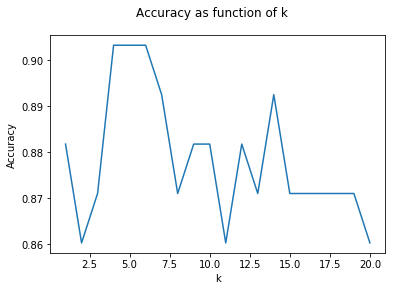

In [38]:
# Building plot
plt.plot(numberofNeighbours, accuracy)
plt.suptitle('Accuracy as function of k')
plt.xlabel('k')
plt.ylabel('Accuracy')